# Assignment Brief: Forecasting with Bayesian Neural Networks

## Deadline: December 02, 2025, 14:00 GMT

## Number of marks available: 15

In this coursework, you will use Python libraries to apply a Bayesian Neural Network model to weather data extracted from Heathrow.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64101_Assignment_part2_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64101_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Blackboard under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already.


### Assessment Criteria
*   Being able to use Monte-Carlo dropout for epistemic uncertainty estimation;
*   Being able to analyse and discuss the impact on uncertainty of various parameters such as dropout rate, training data size, number of epochs etc;
*   Being able to include different type of noise in Bayesian Neural Networks and evaluate how these affect the model’s predictions.
### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code?
* Did you comment your code to make it readable to others?


### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline. Please read [this link](https://documents.manchester.ac.uk/display.aspx?DocID=29825).

### Academic malpractice

Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Academic Malpractice](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

## Bayesian Neural Networks (BNN) (Introduction)
In **Lab4** you explored Bayesian Neural Networks (BNN) on a popular toy dataset often used for binary classification tasks, the "moons" dataset. Unlike traditional neural networks, which provide point estimates of their parameters (weights and biases), BNNs treat these parameters as probability distributions. For Lab4, you used methods like MC Dropout to estimate Bayesian inference for uncertainty quantification. For this exercice, we will explore BNN for a regression problem, more precisely, using Bayesian inference and Bayesian neural networks that deal with weather prediction. The dataset that we will be using is the Heathrow Weather dataset.

There are several packages that have employed BNN to predict time-series data such as:
https://research.google/blog/autobnn-probabilistic-time-series-forecasting-with-compositional-bayesian-neural-networks/ and several papers exploring BNN for probabilistic predictions in various climate related topics, as exemplified below.

[1]Cofiño, A. S., Cano, R., Sordo, C., & Gutiérrez, J. M. (2002). *Bayesian networks for probabilistic weather prediction*. In *15th European Conference on Artificial Intelligence (ECAI)*.
[2]Khan, M. S., & Coulibaly, P. (2006). *Bayesian neural network for rainfall–runoff modeling*.  
Water Resources Research, 42(7). Wiley Online Library.


First let's import some libraries you are going to use in the exercise.

In [ ]:
# --- Setup & configuration ---
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


# Reproducibility
SEED = 42
EPS = 1e-6  # for numerical stability control
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


**Dataset - Heathrow weather data**


We will use the [Heathrow weather dataset](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt) in this notebook.

 The dataset contains per each year and month several quantities, such as the maximum and minimum temperatures (in degrees Celsius), number of days of air frost, rain (mm) and number of hours of sun. We have all enjoyed a very warm summer in 2025, so we want to explore with Bayesian neural networks if next years and months we will enjoy similar temperatures and with what probabilities.


##Examine and prepare the Heathrow dataset

**Load and clean the data**;

 The Heathrow weather dataset contains several issues. if you examine the data you will observe that there is a header in the dataset,  not all attributes start and end at the same year/month. Some of data contain characters such as: '#'.

In [ ]:
# load dataset
url = ("https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt")

# Read raw text, skip header lines until the table starts
df = pd.read_fwf(
    url,
    skiprows=7,  # skip metadata lines
    names=["year", "month", "tmax", "tmin", "af_days", "rain_mm", "sun_hours"],
    na_values=["---", "     "]
)


print(df.head(250))



     year  month  tmax  tmin  af_days  rain_mm  sun_hours
0    1948      1   8.9   3.3      NaN     85.0        NaN
1    1948      2   7.9   2.2      NaN     26.0        NaN
2    1948      3  14.2   3.8      NaN     14.0        NaN
3    1948      4  15.4   5.1      NaN     35.0        NaN
4    1948      5  18.1   6.9      NaN     57.0        NaN
..    ...    ...   ...   ...      ...      ...        ...
245  1968      6  20.6  11.5      0.0     54.9       72.0
246  1968      7  20.7  12.6      0.0     79.4       46.0
247  1968      8  20.2  12.6      0.0     68.2       21.0
248  1968      9  18.8  11.6      0.0    131.4       25.0
249  1968     10  16.5  10.7      0.0     64.2       78.0

[250 rows x 7 columns]


**Examine/plot the data**

You noticed probably that some attributes start in 1957. For simplicity we will use only the data starting with the year 1960. We will also not include year 2025 since data is incomplete. After you cleaned your data, plot the maximum temperature starting with year 1960.
To plot monthly data on a continuous time axis, we convert each `(year, month)` pair
into a **fractional year index**:

$$
 \text{year} + \frac{\text{month} - 1}{12.0}
$$


So data such as January 1960 becomes 1960.00, February 1960 becomes 1960.0833,..., December 1960 becomes 1960.9167.

 You can also add other quantites in your plot such as averages. Do you observe any evidence of climate change?

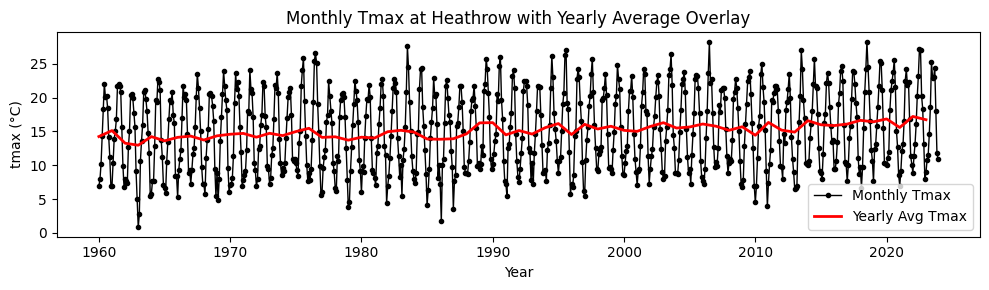

In [ ]:
# Clean and format datetime index
df = df.dropna(subset=["year", "month", "tmax"])
df = df[(df["month"] >= 1) & (df["month"] <= 12)]
df["date"] = pd.to_datetime(dict(year=df.year.astype(int), month=df.month.astype(int), day=1))
df = df.set_index("date").sort_index()

# Filter from 1960-2023 onwards
df = df[(df.index.year >= 1960)& (df.index.year <= 2023)]

# Monthly fractional year
x_monthly = df.index.year + (df.index.month - 1) / 12.0

# Yearly averages
df_yearly = df["tmax"].resample("YE").mean()
x_yearly = df_yearly.index.year
y_tmax_yearly = df_yearly.values

# Plot
plt.figure(figsize=(10,3))

# Monthly line+points
plt.plot(x_monthly, df["tmax"], color="black", linewidth=1, marker='o', markersize=3, label="Monthly Tmax")

# Yearly average line+points on top

plt.plot(x_yearly, y_tmax_yearly, color="red", linewidth=2, label="Yearly Avg Tmax")


plt.xlabel("Year")
plt.ylabel("tmax (°C)")
plt.title("Monthly Tmax at Heathrow with Yearly Average Overlay")
plt.legend()
plt.tight_layout()
plt.show()

**Divide data into training/testing**

Divide your data into training and testing. You can train your model on the years 1960-2009 and test on 2010-2024 since the year 2025 is incomplete. Do this for  the maximum temperature, Tmax.

In [ ]:
# If df.index is datetime:
train_mask = (df.index.year >= 1960) & (df.index.year < 2010)
test_mask  = (df.index.year >= 2010) & (df.index.year <= 2024)

# Apply the masks to both features and target
X_train_np = x_monthly[train_mask]
X_test_np  = x_monthly[test_mask]
y_train_np = df.loc[train_mask, "tmax"].values
y_test_np  = df.loc[test_mask, "tmax"].values

# Convert to PyTorch tensors
import torch
X_train = torch.tensor(X_train_np, dtype=torch.get_default_dtype())
X_test  = torch.tensor(X_test_np,  dtype=torch.get_default_dtype())
y_train = torch.tensor(y_train_np, dtype=torch.get_default_dtype()).view(-1, 1)
y_test  = torch.tensor(y_test_np,  dtype=torch.get_default_dtype()).view(-1, 1)

print(f"Train years: {df.index[train_mask][0].year} → {df.index[train_mask][-1].year}")
print(f"Test years:  {df.index[test_mask][0].year} → {df.index[test_mask][-1].year}")

####get the dimensions:

print('Shapes:')
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test :', X_test.shape,  'y_test :', y_test.shape)




Train years: 1960 → 2009
Test years:  2010 → 2023
Shapes:
X_train: torch.Size([600]) y_train: torch.Size([600, 1])
X_test : torch.Size([168]) y_test : torch.Size([168, 1])


 **Sliding windows**

 Sliding windows are a way to turn a continuous time series into a set of supervised learning samples that an MLP (or other ML model) can use.
Instead of feeding the network a single time point and asking it to guess the future, you feed it a block of past values (the “window”) and train it to predict the next value (or values).

The window size determines how much historical data the model uses to make predictions. For instance, a weather forecasting model might use a 3-day window (temperature, humidity, etc.) to predict the next day’s temperature. Developers can also adjust the forecast horizon—the number of future steps to predict.for this particular dataset, the Heathrow airport weather we will past the 2 years (24months) to predict next months weather.


**The following code divide  the data using sliding windows of 24 months:**



In [ ]:

LOOKBACK = 24  # past 24 months -> predict next month
HORIZON  = 1

def make_windows_from_series(series_1d: torch.Tensor, lookback=24, horizon=1):
    v = series_1d.view(-1).to(dtype=torch.get_default_dtype())
    Xs, ys = [], []
    for t in range(lookback, v.shape[0] - horizon + 1):
        Xs.append(v[t-lookback:t])          # [lookback]
        ys.append(v[t + horizon - 1])       # scalar target
    X = torch.stack(Xs)                     # [N, lookback]
    y = torch.stack(ys).view(-1, 1)         # [N, 1]
    return X, y

# Train windows from y_train (ignore X_train years)
Xtr_win, ytr_win = make_windows_from_series(y_train.squeeze(-1), LOOKBACK, HORIZON)

# Test windows need train tail as context for first window
y_test_with_ctx = torch.cat([y_train.squeeze(-1)[-LOOKBACK:], y_test.squeeze(-1)], dim=0)
Xte_all, yte_all = make_windows_from_series(y_test_with_ctx, LOOKBACK, HORIZON)
# Keep only windows that end inside the real test segment
num_te = y_test.shape[0] - HORIZON + 1
Xte_win, yte_win = Xte_all[-num_te:], yte_all[-num_te:]

print("Train windows:", Xtr_win.shape, ytr_win.shape)  # e.g. [576, 24] [576, 1]
print("Test  windows:", Xte_win.shape, yte_win.shape)  # e.g. [168, 24] [168, 1]


print("Train windows:", Xtr_win.shape, ytr_win.shape)
print(Xtr_win[:5])  # first 5 input windows
print("Target  windows (should start with year 1962):")

print(ytr_win[:24])  # first 5 targets


print("Test windows:", Xte_win.shape, yte_win.shape)
print(Xte_win[:5])  # first 5 input windows
print(yte_win[:5])  # first 5 targets


Train windows: torch.Size([576, 24]) torch.Size([576, 1])
Test  windows: torch.Size([168, 24]) torch.Size([168, 1])
Train windows: torch.Size([576, 24]) torch.Size([576, 1])
tensor([[ 6.9000,  7.9000, 10.2000, 14.3000, 18.4000, 22.1000, 20.1000, 20.3000,
         18.5000, 14.2000, 11.2000,  6.9000,  6.9000, 10.3000, 13.9000, 15.0000,
         16.8000, 21.7000, 22.1000, 21.7000, 20.9000, 15.6000,  9.9000,  6.8000],
        [ 7.9000, 10.2000, 14.3000, 18.4000, 22.1000, 20.1000, 20.3000, 18.5000,
         14.2000, 11.2000,  6.9000,  6.9000, 10.3000, 13.9000, 15.0000, 16.8000,
         21.7000, 22.1000, 21.7000, 20.9000, 15.6000,  9.9000,  6.8000,  7.9000],
        [10.2000, 14.3000, 18.4000, 22.1000, 20.1000, 20.3000, 18.5000, 14.2000,
         11.2000,  6.9000,  6.9000, 10.3000, 13.9000, 15.0000, 16.8000, 21.7000,
         22.1000, 21.7000, 20.9000, 15.6000,  9.9000,  6.8000,  7.9000,  7.6000],
        [14.3000, 18.4000, 22.1000, 20.1000, 20.3000, 18.5000, 14.2000, 11.2000,
          6.9

## Section 1: Define and train a small MLP
Multilayer Perceptron (MLP) Networks are simplistic and can be used as initial model for forcasting, time-series problem. in this section you will set a simple 2 layer MLP network. This network model will be called later on.

In [ ]:
class ConventionalNN(nn.Module):
    def __init__(self, features):
        super(ConventionalNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X  # raw regression output

    def loss_fn(self, X, y, reg_lambda=0., reg_ord=2):
        y_pred = self.forward(X)
        loss = F.mse_loss(y_pred, y)
        if reg_lambda != 0.:
            reg_term = sum(torch.linalg.vector_norm(param, ord=reg_ord) ** reg_ord
                           for param in self.parameters())
            loss = loss + reg_lambda / y.shape[0] * reg_term
        return loss


In [ ]:
def train(
        model, X, y, batch_size=32, lr=0.01, reg_lambda=0., reg_ord=2,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, reg_lambda, reg_ord
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses



In [ ]:
LOOKBACK = Xtr_win.shape[1]           # e.g., 24
features = [LOOKBACK, 16, 8, 1]       # small 2-layer MLP
mlp = ConventionalNN(features)
print(LOOKBACK)
print(mlp)

24
ConventionalNN(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


**Question 1 (2p)** Evaluate results MLP.  

PyTorch L1 loss function is also known as Mean Absolute Error (MAE). Explain in your own words what the MAE value means in the context of your temperature prediction task.
Compare it briefly with the Root Mean Squared Error (RMSE) value. What does each metric tell you about your model’s performance? Plot your prediction versus the actual data, what can you tell about the accuracy of your model?


**What to do**
1) Pick `lr`, `epochs`, and `print_iters` and fill them in.  **Hint**  Start with `lr = 1e-3`, `epochs = 1000`, `print_iters = 200`
2) Train the model and plot the training loss.  
3) Evaluate on the test set: compute RMSE and MAE.  
4) Print the first 10 predictions vs actuals.  
5) Plot the whole test sequence (Actual vs Predicted).
6) Discuss your results.


In [ ]:
##Train
mlp, loss_list = train(mlp, Xtr_win, ytr_win, batch_size=y_train.size(-2), lr=---, epochs=---,print_iters=---, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")


#Evaluate and compute RMSE and MAE
mlp.eval()
with torch.no_grad():
    yhat_test = mlp(Xte_win.to(device)).cpu()

rmse = F.mse_loss(yhat_test, yte_win).sqrt().item()
mae  = F.l1_loss(yhat_test, yte_win).item()

#Compare first few predictions and actual
df_compare = pd.DataFrame({
    "Actual": yte_win.view(-1).numpy(),
    "Predicted": yhat_test.view(-1).numpy()
})
# print first 10 rows

#Plot
plt.figure(figsize=(10,4))
plt.plot(----, label="Actual")
plt.plot(----, label="Predicted")
plt.xlabel("Test sample index")
plt.ylabel("Tmax (normalized or °C)")
plt.legend()
plt.title("MLP Predictions vs Actual (Test set)")
plt.tight_layout()
plt.show()



## Section 2: **Monte Carlo dropout**


**Monte Carlo (MC) Dropout**

MC Dropout is a simple yet effective method to estimate model uncertainty follow the [method described by Gal and Ghahramani.](https://arxiv.org/abs/1506.02142) Dropout is a technique that involves 'dropping out' a node during each training iteration. This can actually help counteract overfitting and improve performance as it means that nodes will no longer need to account so strongly for a previous layers 'mistakes' in training. How this may be used for an estimation of uncertainty is by the following:

1. Using dropout during both training and inference.
2. Running multiple forward passes with dropout at test time.
3. Using the mean of these passes as the prediction and the variance as a measure of uncertainty.

Another way of saying this, dropout is only active during training (model.train()), and turned off during evaluation (model.eval()). But for uncertainty estimation we deliberately keep dropout active at inference time by leaving the model in training mode (but with torch.no_grad() so no weights are updated)

Here's how we can implement MC Dropout:

In [ ]:
# %% MC Dropout regressor (no sigmoid; MSE loss)
class MCDropoutReg(nn.Module):
    def __init__(self, features, dropout_rate=0.1):
        """
        features: e.g. [LOOKBACK, 16, 8, 1]
        """
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=dropout_rate))  # MC dropout in hidden layers

    def forward(self, X):
        if X.ndim == 3:  # flatten if [N, L, F]
            X = X.reshape(X.shape[0], -1)
        for layer in self.layers:
            X = layer(X)
        return X  # [N, 1]

    def loss_fn(self, X, y):
        return F.mse_loss(self.forward(X), y)


So far, our neural network predictions gave us only a single number (the mean).  
But in practice we also want to know **how uncertain** the model is about its prediction.Dropout is usually applied only during training, where some neurons are randomly switched off
to prevent overfitting.  
In **Monte Carlo (MC) Dropout**, we also keep dropout active during inference
and perform **multiple forward passes** on the same input.  

- Each pass produces a slightly different prediction due to the random dropout mask.  
- Collecting many such predictions gives us a **distribution of predictions**.  
- From this distribution we can estimate:
  - The **predictive mean** (average across passes).  
  - The **epistemic uncertainty** (standard deviation across passes).

This allows us to form uncertainty bands around the predictions.

**Plotting Uncertainty**

A common way to visualize uncertainty is to plot the predicted mean along with a band that
covers (for example) ±2 standard deviations:

$$
\hat{y}(x) \;\pm\; 2 \, \hat{\sigma}(x)
$$

**Coverage**

We can check if our uncertainty estimates are well calibrated by computing coverage.  

A prediction interval (PI) at confidence level $\alpha$ is defined as:

$$
\text{PI}_{\alpha}(x) = \big[ \mu(x) - k \cdot \sigma(x), \; \mu(x) + k \cdot \sigma(x) \big]
$$

where $k$ depends on $\alpha$ (e.g. $k \approx 1.64$ for 90%, $k \approx 1.96$ for 95%) and coming  from the inverse cumulative distribution function (CDF) of the standard normal distribution.

The **coverage** is the fraction of actual data points that fall inside these intervals:

$$
\text{Coverage} = \frac{1}{N} \sum_{i=1}^N \mathbf{1}\Big( y_i \in \text{PI}_{\alpha}(x_i) \Big)
$$

- If the model is well calibrated, empirical coverage should match the target (e.g. ~0.95 for PI95).  If coverage is too low, the intervals are too narrow,the model is overconfident. If coverage is too high, the intervals are too wide, the model is underconfident.  




**Question 2 (3p)** Monte Carlo Dropout, plot uncertainty and coverage

Your goal is to train an MC Dropout regressor on sliding windows of Heathrow Tmax (raw °C), then:
1) run MC sampling to estimate mean and epistemic std,
2) plot mean ± 2σ,
3) compute PI90 / PI95 coverage. You will use these to compare the model behaviour in the next steps.

You would need to fill the blanks (_____), choose sensible hyperparameters for training such as `lr`, `epochs`. You can use 200 MC samples for stable uncertainty.

You should discuss your findings and results. Is this model improved with comparison to the small MLP in Section 1?

In [ ]:

from torch import optim

# ---------------------------
# Training loop
# ---------------------------
def train(model, X, y, batch_size=256, lr=1e-3, epochs=300, print_iters=25, device=torch.device("cpu")):
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=min(batch_size, len(ds)), shuffle=True)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for ep in range(epochs):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = model.loss_fn(xb, yb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        if (ep+1) % print_iters == 0:
            print(f"Epoch {ep+1}/{epochs} - loss: {loss.item():.6f}")
    return model, losses

# ---------------------------
# MC inference (fill blanks)
# ---------------------------
@torch.no_grad()
def mc_predict_mean_std(model, X, num_samples=_____, batch_size=None, device=torch.device("cpu")):  # FILL: e.g., 200
    model.to(device)
    model.____()   # FILL: keep dropout active during inference
    ds = TensorDataset(X)
    if batch_size is None:
        batch_size = len(ds)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    preds = []
    for _ in range(num_samples):
        outs = []
        for (xb,) in dl:
            outs.append(model(xb.to(device)))
        preds.append(torch.cat(outs, dim=0))   # shape [N, 1]
    preds = torch.stack(preds, dim=0)         # shape [S, N, 1]
    mean  = preds.____(dim=0)                 # FILL
    std   = preds.____(dim=0)                 # FILL
    return mean.cpu(), std.cpu()

# ---------------------------
# Instantiate, train (fill HPs)
# ---------------------------
LOOKBACK = Xtr_win.shape[1]
features = [LOOKBACK, 16, 8, 1]     # small MLP
dropout_rate = 0.1

mc = MCDropoutReg(features, dropout_rate=dropout_rate)

mc, loss_hist = train(
    mc, Xtr_win, ytr_win,
    batch_size=min(256, len(Xtr_win)),
    lr=_____,            # FILL: e.g., 1e-3
    epochs=_____,        # FILL: e.g., 5000 or 10000
    print_iters=_____,   # FILL: e.g., 500 or 1000
    device=device
)

# ---------------------------
# MC predictions + metrics
# ---------------------------
mean_te, std_te = mc_predict_mean_std(mc, Xte_win, num_samples=_____, device=device)  # FILL: e.g., 200

rmse = F.mse_loss(mean_te, yte_win).sqrt().item()
mae  = F.l1_loss(mean_te, yte_win).item()
print({"rmse": rmse, "mae": mae})

# ---------------------------
# Plot: training loss
# ---------------------------
plt.figure(figsize=(7,3))
plt.plot(loss_hist)
plt.xlabel("iteration"); plt.ylabel("loss (MSE)")
plt.title("MC Dropout — Training Loss")
plt.tight_layout(); plt.show()

# ---------------------------
# Plot: uncertainty band
# ---------------------------
mu = mean_te.view(-1).numpy()
sd = std_te.view(-1).numpy()
y  = yte_win.view(-1).numpy()
x  = range(len(mu))

plt.figure(figsize=(10,4))
plt.plot(x, y,  label="Actual")
plt.plot(x, mu, label="Predicted (mean)")
plt.fill_between(x, ---- , ----, alpha=0.25, label="±2σ (epistemic)")
plt.xlabel("Test sample index"); plt.ylabel("Tmax (°C)")
plt.title("Heathrow Tmax — MC Dropout mean ± uncertainty")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------
# Coverage (PI90 / PI95)
# ---------------------------
def coverage(y_true, y_mean, y_std, k=1.96):
    lower, upper = y_mean - k*y_std, y_mean + k*y_std
    return float(np.mean((y_true >= lower) & (y_true <= upper)))

pi90_q5 = coverage(y, mu, sd, k=_____)   # FILL for 90% CI
pi95_q5 = coverage(y, mu, sd, k=_____)   # FILL for 95% CI
print({"PI90_coverage_q5": round(pi90_q5, 3),
       "PI95_coverage_q5": round(pi95_q5, 3)})


NameError: name '_____' is not defined

**Question 3 (3p) Impacts on Uncertainty**



Which of our previous modelling decisions have an impact on our uncertainty estimation?

Similarly to what you have done in Lab 4, discuss the effect of a:

1. Change in the dropout rate (for speedup use epochs 1000)
2. Change in the training data size (for example use only half the data)
3. Change in number of epochs

You should use for loops for Q3. One example is below for number 1 (change in the dropout rate). You need to write your solution for number 2 and 3 (data size and epochs).

In [ ]:
# %% 1) Change dropout rate
for p in [0.05, 0.1, 0.2, 0.3]:
    model = MCDropoutReg([LOOKBACK, 16, 8, 1], dropout_rate=----)
    model, _ = train(model, Xtr_win, ytr_win, lr=1e-3, epochs=5000, device=device, print_iters=500)
    mu_te, sd_te = mc_predict_mean_std(model, Xte_win, num_samples=100, device=device)
    rmse = F.mse_loss(mu_te, yte_win).sqrt().item()
    print(f"dropout={p:.2f}  test_RMSE={rmse:.3f}  avg_std={sd_te.mean().item():.3f}")

SyntaxError: invalid syntax (ipython-input-2025933272.py, line 3)

##Section 3: Modelling noise in BNN

**Modelling Noise in Bayesian Neural Networks**


So far the conventional MLP you employed here predicts only the mean temperature, trained with MSE. This assumes constant noise across all months. This is called homoscedastic noise.  The MC Dropout model still predicts only the mean, but with dropout at test time. This adds epistemic uncertainty (uncertainty in weights because of limited data). Neither of these models let the noise depend on the input.

So far, our likelihood has assumed a constant variance term:

$$
y \mid x, \theta \sim \mathcal{N}(f(x;\theta), \sigma_n^2).
$$

This is known as **homoscedastic noise** — the model assumes that all data points
are equally noisy, regardless of their input location.
In many real-world datasets (including weather data), the uncertainty is not uniform.
For example, measurements in stable seasons (e.g. winter) may be less variable. Measurements in transitional seasons (e.g. spring, autumn) may be more uncertain.

This motivates **heteroscedastic noise models** — models where the variance can change with the input — as discussed in [this paper](https://doi.org/10.48550/arXiv.2502.05244).


**Heteroscedastic Bayesian Neural Network**

To capture this, we let the neural network output both a mean and a variance:

$$
y \mid x, \theta \sim \mathcal{N}(\mu(x;\theta), \sigma^2(x;\theta)),
$$

with

$$
\mu(x;\theta) = f_1(x;\theta), \qquad
\sigma^2(x;\theta) = \exp\!\big(f_2(x;\theta)\big).
$$

- $f_1(x;\theta)$ predicts the mean value of $y$.  
- $f_2(x;\theta)$ predicts the log-variance (we exponentiate to ensure $\sigma^2 > 0$).

If the data at $x$ is consistent, the network predicts a small variance. If the data at $x$ is highly variable or ambiguous, the network predicts a larger variance. In this way, the model can distinguish between “hard-to-predict” regions of the input space and “easy-to-predict” regions, providing a more realistic estimate of uncertainty.




**Question 4 (5p) Implement Heteroscedastic Noise**

**Step 1** Extend your MC Dropout model to also output a variance term by adding a second output head that predicts $\log \sigma^2(x)$ alongside $\mu(x)$.

**Step 2**  Replace MSE with the Gaussian negative log-likelihood:  
     $$
     \mathcal{L}(\theta) =
     \frac{1}{2}\log\sigma^2(x;\theta) +
     \frac{(y - \mu(x;\theta))^2}{2\sigma^2(x;\theta)}.
     $$

**Step 3**  Train on Heathrow Tmax data (1960–2009) and test on 2010–2024. Run multiple forward passes with dropout at test time.

**Step 4**   Plot predicted mean vs actual Tmax with **95% prediction intervals**  
     Use $\mu \pm 2\sigma_{total}$, where $\sigma_{total}$ combines epistemic + aleatoric uncertainty). Compare your intervals to the earlier MC Dropout-only model.




In [ ]:
# Heteroscedastic BNN (raw °C) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class MCDropoutHetero(nn.Module):
    """
    Backbone with MC Dropout + two heads:
      - mu_head:  predicts mean Tmax (°C)
      - var_head: predicts variance (°C^2) via softplus (ensures positivity)
    """
    def __init__(self, features, dropout_rate=0.1):
        super().__init__()
        layers = []
        for i in range(len(features) - 1):
            layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p=dropout_rate))
        self.backbone = nn.Sequential(*layers)
        last_dim = features[-1]
        #FILL: add a second output head that predicts log𝜎2(𝑥) alongside 𝜇(𝑥)
        self.mu_head  = nn.Linear(last_dim, 1)
        self.----

    def forward(self, X):
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        h  = self.backbone(X)
        mu = self.mu_head(h)
        var = F.softplus(self.var_head(h)) + 1e-6
        return mu, var

    def loss_fn(self, X, y):
        # Heteroscedastic Gaussian NLL
        mu, var = self.forward(X)
        nll = ----#FILL
        return nll.mean()


To train you can use the following:

In [ ]:
#  Train (raw °C) ===
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

def train(model, X, y, batch_size=256, lr=1e-3, epochs=3000, print_iters=300, device=torch.device('cpu')):
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=min(batch_size, len(ds)), shuffle=True)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for ep in range(epochs):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = model.loss_fn(xb, yb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        if (ep+1) % print_iters == 0:
            print(f"Epoch {ep+1}/{epochs} - loss: {loss.item():.6f}")
    return model, losses

LOOKBACK = Xtr_win.shape[1]  # e.g., 24
features_hetero = [LOOKBACK, 32, 16]   # tweak if desired
dropout_rate = 0.1

het = MCDropoutHetero(features_hetero, dropout_rate=dropout_rate)
device = torch.device('cpu')  # or 'cuda' if available and tensors are on GPU
het, het_loss_hist = train(het, Xtr_win, ytr_win,
                           batch_size=min(256, len(Xtr_win)),
                           lr=1e-3, epochs=3000, print_iters=300, device=device)

plt.figure(figsize=(7,3))
plt.plot(het_loss_hist)
plt.xlabel("iteration"); plt.ylabel("loss (NLL)")
plt.title("Heteroscedastic BNN — Training Curve (raw °C)")
plt.tight_layout(); plt.show()



In [ ]:
# MC prediction (raw °C) ===

@torch.no_grad()
def mc_predict_hetero_raw(model, X, num_samples=200, batch_size=None, device=torch.device('cpu')):
    """
    Returns: pred_mean, aleatoric_std, epistemic_std, total_std  (all [N,1], in °C)
    """
    model.to(device)
    model.train()  # keep dropout active for MC sampling
    ds = TensorDataset(X)
    if batch_size is None:
        batch_size = len(ds)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    mu_samps, var_samps = [], []
    for _ in range(num_samples):
        mus, vars_ = [], []
        for (xb,) in dl:
            mu, var = model(xb.to(device))  # mu: °C, var: °C^2
            mus.append(mu)
            vars_.append(var)
        mu_samps.append(torch.cat(mus,  dim=0))   # [N,1]
        var_samps.append(torch.cat(vars_, dim=0)) # [N,1]

    mu_samps  = torch.stack(mu_samps,  dim=0)  # [S,N,1]
    var_samps = torch.stack(var_samps, dim=0)  # [S,N,1]

    pred_mean     = ---# FILL
    epistemic_std = ---# FILL
    aleatoric_var = ---# FILL                       # [N,1] °C^2
    total_std     = ---# FILL EPISTEMIC AND ALEATORIC
    aleatoric_std = ---# FILL                  # [N,1] °C
    return pred_mean.cpu(), aleatoric_std.cpu(), epistemic_std.cpu(), total_std.cpu()

# Run prediction on your test windows
mu_te, sd_alea_te, sd_epi_te, sd_tot_te = mc_predict_hetero_raw(het, Xte_win, num_samples=200, device=device)


##Conclusions/Discussions

**Question 5 (2p)**
Evaluate your results. Does heteroscedastic noise offer better predictions? Draw overall conclusions for this experiment.